# Run a trained model on images and show results

In [1]:
import sys
sys.path.append("../src")

In [9]:
import os
import json

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import LogNorm

from slim_models.nets import resnet_v1
from slim_models.preprocessing import vgg_preprocessing
from models import model_fn
from tools.utils import ImageDecoder

%matplotlib inline

In [3]:
class_id_filepath = "../data/interim/tfrecords/class.json"
with open(class_id_filepath, "rt") as f:
    name_to_class_id = json.loads(f.read())

id_to_class_name = {v: k for k, v in name_to_class_id.items()}

In [4]:
val_metadata_filepath = "../data/interim/tfrecords/recycle-val_metadata.json"
with open(val_metadata_filepath, "rt") as f:
    val_metadata = json.loads(f.read())
    
samples_per_class = val_metadata["samples_per_class"]

In [5]:
def input_fn(filepaths):
    dataset = tf.data.Dataset.from_tensor_slices(filepaths)
    
    def read_file(filepath):
        image_str = tf.read_file(filepath)
        image_decoded = tf.image.decode_image(image_str)
        return image_decoded
    
    def preprocess(image):
        image_size = resnet_v1.resnet_v1_101.default_image_size
        image = vgg_preprocessing.preprocess_image(image, image_size,
                                                   image_size,
                                                   is_training=False)
        image = tf.expand_dims(image, 0)
        return image
        
    dataset = dataset.map(read_file)
    dataset = dataset.map(preprocess)
    iterator = dataset.make_one_shot_iterator()
    features = {
        "image": iterator.get_next()
    }
    labels = tf.constant(1)
    return features, labels

In [6]:
model_dir = "../logs/REFT00/"
params = {
    "num_classes": 30,
    "network_name": "resnet_v1_101"
}
estimator = tf.estimator.Estimator(model_fn, model_dir=model_dir, params=params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../logs/REFT00/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa84e1d6d68>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [11]:
predict_filepaths = [
    "/home/ubuntu/github/ai/recycle/data/raw/split/val/re_5_Glass_bottle_+_Glass_jar_+_Plastic_bottle/empty_plastic_bottles_000026.jpg",
    "/home/ubuntu/github/ai/recycle/data/raw/split/val/re_12_Paper_bag/paper_bag_2_000071.jpg",
    "/home/ubuntu/github/ai/recycle/data/raw/split/val/non_3_Paper_with_heavy_wax_+_plastic_wrappers/candy_wrapper_000018.jpg",
    "/home/ubuntu/Pictures/bananas.jpg",
    "/home/ubuntu/Downloads/20171107_201521.jpg",
    "/home/ubuntu/Downloads/20171117_151426.jpg",
    "/home/ubuntu/github/ai/recycle/data/raw/split/val/re_14_Paper_cups/paper_cups_000214.jpg"
]

predict_filepaths = "/home/ubuntu/Pictures/recycle/"

In [12]:
if isinstance(predict_filepaths, str):
    folder = predict_filepaths
    predict_filepaths = []
    for dirpath, dirnames, filenames in os.walk(folder):
        for filename in filenames:
            predict_filepaths.append(os.path.join(dirpath, filename))
            
    predict_filepaths = sorted(predict_filepaths)
predict_filepaths

['/home/ubuntu/Pictures/recycle/vlcsnap-2017-12-04-16h08m15s559.png',
 '/home/ubuntu/Pictures/recycle/vlcsnap-2017-12-04-16h10m13s114.png',
 '/home/ubuntu/Pictures/recycle/vlcsnap-2017-12-04-16h10m35s501.png',
 '/home/ubuntu/Pictures/recycle/vlcsnap-2017-12-04-16h32m26s732.png',
 '/home/ubuntu/Pictures/recycle/vlcsnap-2017-12-04-16h32m33s604.png',
 '/home/ubuntu/Pictures/recycle/vlcsnap-2017-12-04-16h32m51s982.png',
 '/home/ubuntu/Pictures/recycle/vlcsnap-2017-12-04-16h33m10s673.png',
 '/home/ubuntu/Pictures/recycle/vlcsnap-2017-12-04-16h36m25s012.png',
 '/home/ubuntu/Pictures/recycle/vlcsnap-2017-12-04-16h40m13s129.png',
 '/home/ubuntu/Pictures/recycle/vlcsnap-2017-12-04-16h40m14s606.png']

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ../logs/REFT00/model.ckpt-22500


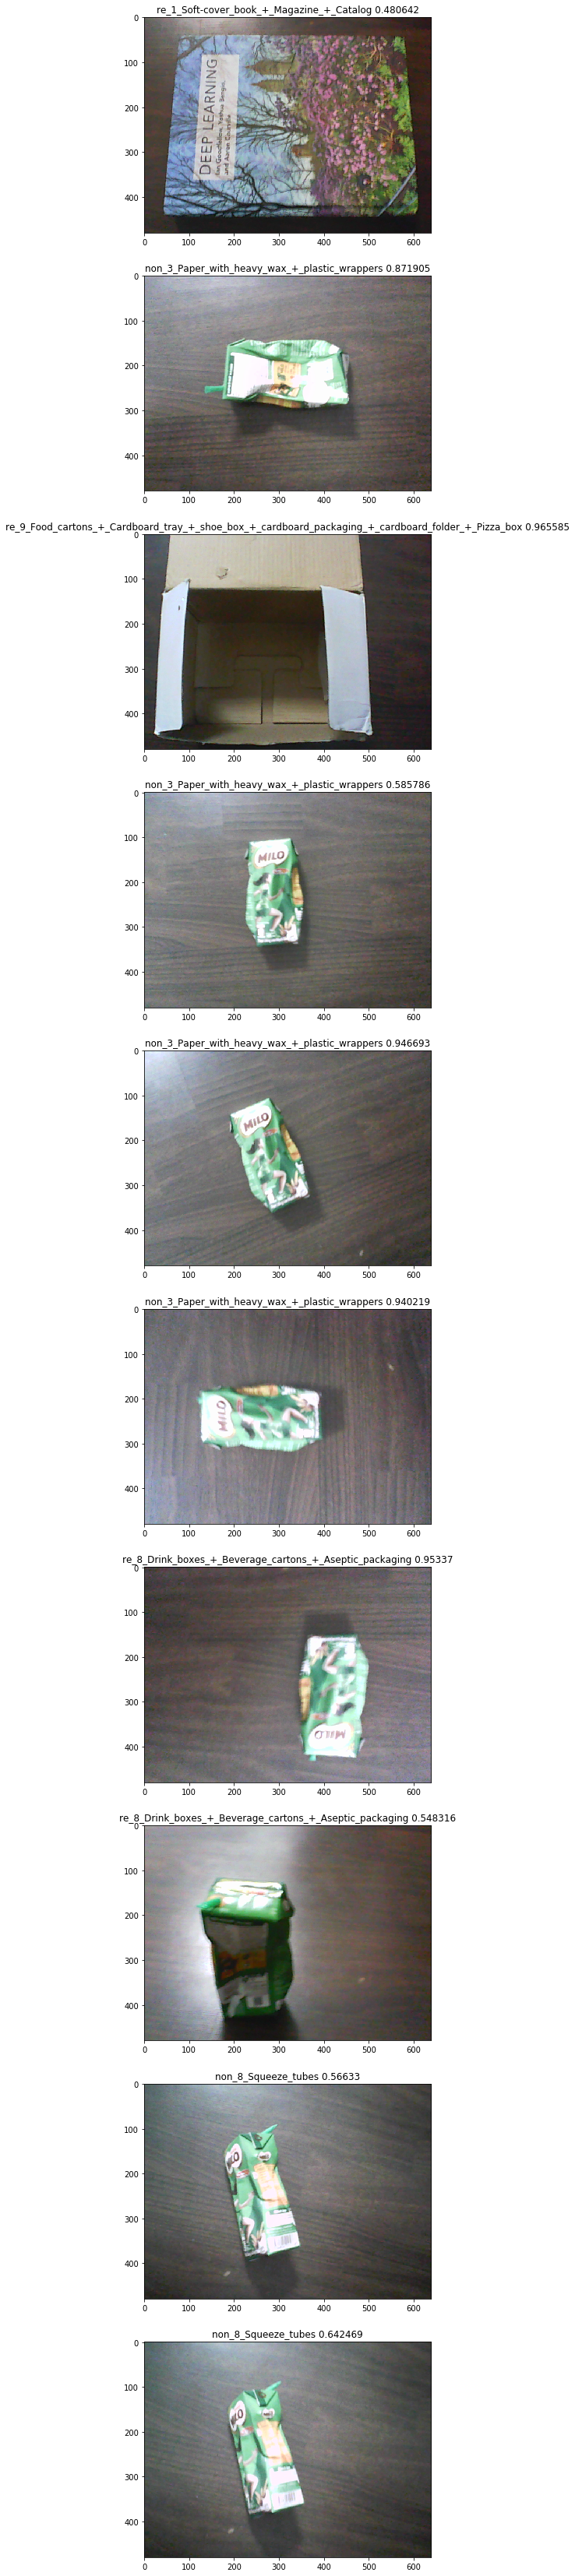

In [14]:
fig, axs = plt.subplots(len(predict_filepaths), 
                        figsize=(10, 6 * len(predict_filepaths)))
for i, pred in enumerate(estimator.predict(
        input_fn=lambda: input_fn(predict_filepaths))):
    class_id = pred['class_id'][0]
    prob = pred['probs'][0]
    img = plt.imread(predict_filepaths[i])
    axs[i].imshow(img)
    axs[i].set_title(id_to_class_name[class_id] + " " + str(prob[class_id]))
    

# Confusion matrix of trained model on validation data

In [5]:
def input_fn_from_tfrecords(file_patterns, batch_size, visualize=False):
    """Input function for Resnet Estimator."""
    filenames = []
    for pattern in file_patterns.split(","):
        filenames.extend(tf.gfile.Glob(pattern))

    def parser(record):
        """Parse tf.Example protobuf."""
        keys_to_features = {
            "image/data": tf.FixedLenFeature((), tf.string),
            "label": tf.FixedLenFeature((), tf.int64)
        }
        parsed = tf.parse_single_example(record, features=keys_to_features)

        image = tf.image.decode_image(parsed["image/data"], channels=3)
        label = parsed["label"]

        return image, label

    def preprocess(image, label):
        """Preprocess image for Resnet."""
        image_size = resnet_v1.resnet_v1_101.default_image_size
        image = vgg_preprocessing.preprocess_image(image, image_size,
                                                   image_size,
                                                   is_training=False)
        if visualize:
            image = vgg_preprocessing._mean_image_subtraction(
                image, [-vgg_preprocessing._R_MEAN, 
                        -vgg_preprocessing._G_MEAN, 
                        -vgg_preprocessing._B_MEAN])
        label = tf.to_int32(label)
        return {"image": image}, label

    with tf.device('/cpu:0'):
        # Create the dataset
        dataset = tf.data.TFRecordDataset(filenames, buffer_size=256 * 2 ** 20)
        dataset = dataset.map(parser, num_parallel_calls=batch_size * 10)
        dataset = dataset.map(preprocess,
                              num_parallel_calls=batch_size * 10)
        dataset = dataset.batch(batch_size=batch_size)
        dataset = dataset.prefetch(batch_size)

        # Create iterator for the dataset
        iterator = dataset.make_one_shot_iterator()
        features, labels = iterator.get_next()

    return features, labels

In [6]:
model_dir = "../logs/REFT00/"
params = {
    "num_classes": 30
}
estimator = tf.estimator.Estimator(model_fn, model_dir=model_dir, params=params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../logs/REFT00/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7311d72be0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [7]:
batch_size = 64
file_patterns = "../data/interim/tfrecords/recycle-val-*"
predictions = None
probs = None
for i, pred in enumerate(estimator.predict(
        input_fn=lambda: input_fn_from_tfrecords(file_patterns, batch_size))):
    class_ids = pred['class_ids']
    p = pred["probs"][np.arange(len(class_ids)), class_ids]
    if predictions is None:
        predictions = class_ids
        probs = p
    else:
        predictions = np.hstack((predictions, class_ids))
        probs = np.hstack((probs, p))

INFO:tensorflow:Restoring parameters from ../logs/REFT00/model.ckpt-22500


In [24]:
f, l = input_fn_from_tfrecords(file_patterns, batch_size, visualize=True)
images = None
labels = None
with tf.Session() as sess:
    try:
        while True:
            a, b = sess.run([f, l])
            if labels is None:
                labels = b
                images = a["image"]
            else:
                labels = np.hstack((labels, b))
                images = np.concatenate((images, a["image"]))
    except Exception as e:
        pass
    
images = images.astype(np.uint8)
print("Accuracy on validation set:", np.mean(predictions == labels))

Accuracy on validation set: 0.832369942197


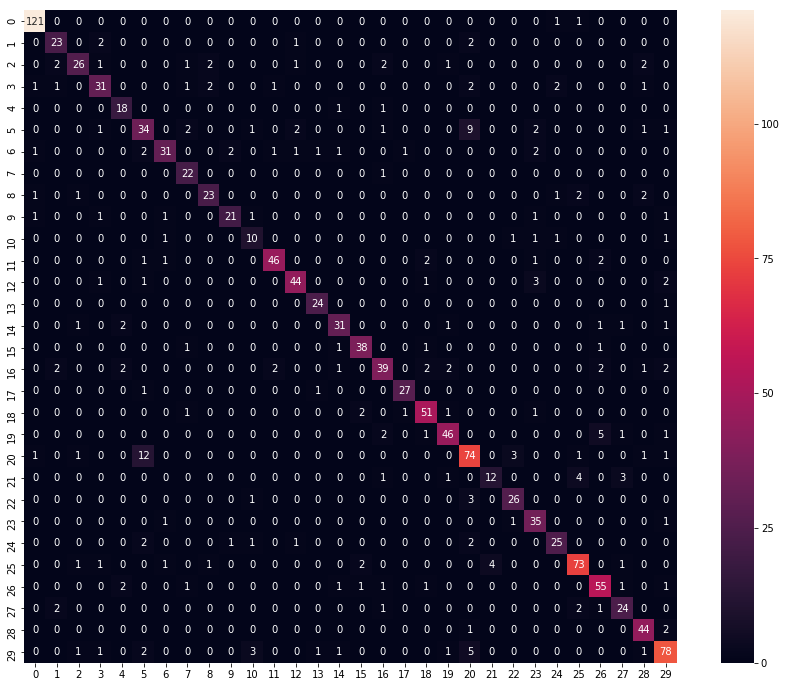

In [67]:
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(16, 12))
cm_log = np.round(np.log(cm, where=((cm > 0) & (np.eye(len(cm), dtype=np.bool_))))).astype(np.int32)
sns.heatmap(cm, annot=True, fmt="d", square=True)
plt.xlabel("Prediction")
plt.ylabel("Label")

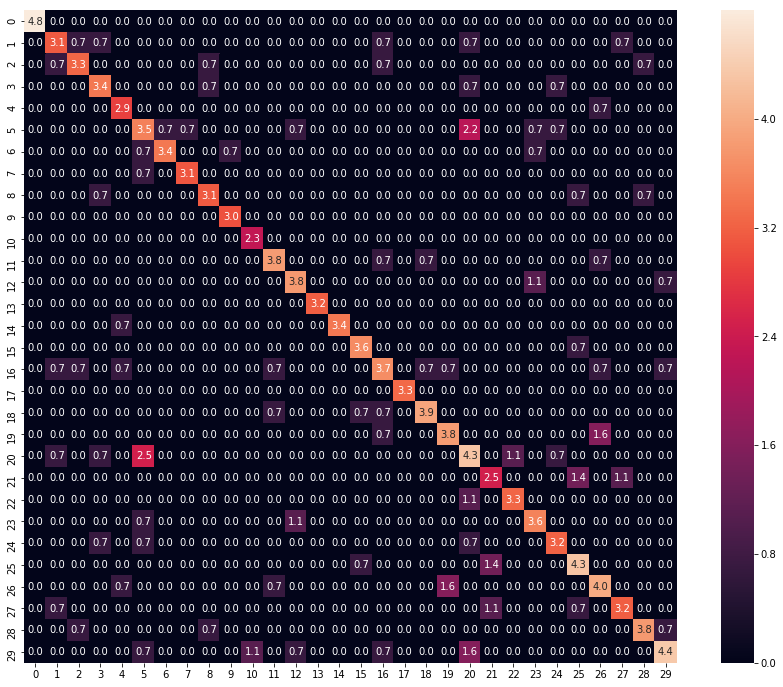

In [52]:
plt.figure(figsize=(16, 12))
cm_log = np.log(cm, where=(cm > 0))
sns.heatmap(cm_log, annot=True, fmt=".1f", square=True)
plt.xlabel("Prediction")
plt.ylabel("Label")

# Binary accuracy for recycle/non-recycle classes

In [11]:
binary_labels = labels > 9
binary_predictions = predictions > 9

In [12]:
print("Binary accuracy:", np.mean(np.equal(binary_labels, 
                                           binary_predictions).astype(np.float32)))

Binary accuracy: 0.929191


# Per-class accuracy

In [69]:
row_sum = np.sum(cm, axis=1)
per_class_acc = np.diag(cm) / row_sum
print("Mean per-class accuracy:", np.mean(per_class_acc))

Mean per-class accuracy: 0.820619980735


In [54]:
sorted_idxs = [t[0] for t in sorted(enumerate(per_class_acc), key=lambda x: x[1])]
for idx in sorted_idxs:
    print("{:2d} {:41}: {:.6f} {:3d}".format(idx, id_to_class_name[idx][:40], 
                                       per_class_acc[idx], samples_per_class[idx]))

21 re_20_Plastic_jar                        : 0.571429  21
 5 non_5_Hardcover_books                    : 0.629630  54
10 re_10_Flattened_cardboard_+_Used_cardboa : 0.666667  15
 2 non_2_Pouches                            : 0.684211  38
16 re_16_Acelate_boxes_+_clamshell_containe : 0.709091  55
 6 non_6_Soiled_or_soft_paper               : 0.720930  43
 3 non_3_Paper_with_heavy_wax_+_plastic_wra : 0.738095  42
 8 non_8_Squeeze_tubes                      : 0.766667  30
 9 non_9_Foam                               : 0.777778  27
24 re_4_Wrapping_paper                      : 0.781250  32
20 re_1_Soft-cover_book_+_Magazine_+_Catalo : 0.787234  94
27 re_7_Plastic_Jug                         : 0.800000  30
14 re_14_Paper_cups                         : 0.815789  38
 1 non_1_Plastic_bags                       : 0.821429  28
19 re_19_Rigid_plastic_housewares           : 0.821429  56
29 re_9_Food_cartons_+_Cardboard_tray_+_sho : 0.829787  94
12 re_12_Paper_bag                          : 0.846154  

Text(0,0.5,'Accuracy')

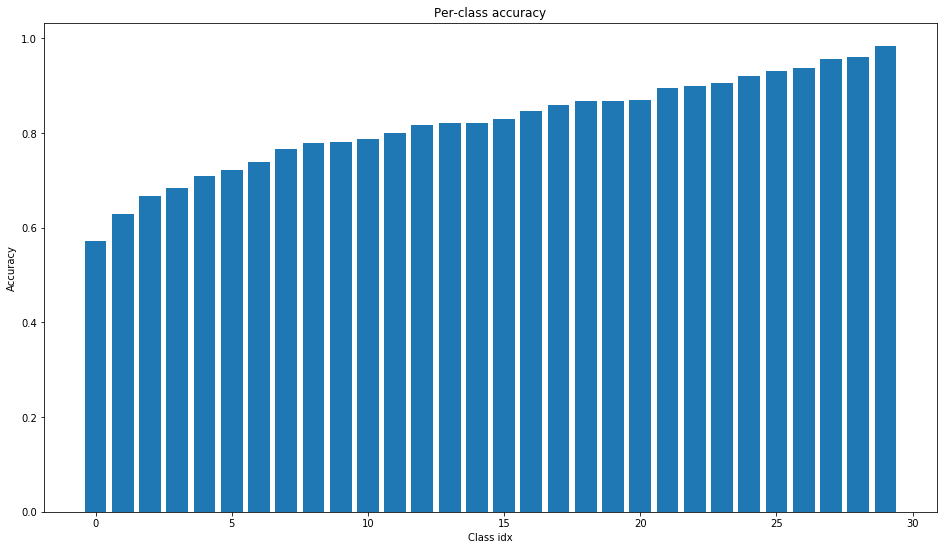

In [73]:
plt.figure(figsize=(16, 9))
plt.bar(range(len(per_class_acc)), sorted(per_class_acc))
plt.title("Per-class accuracy")
plt.xlabel("Class idx")
plt.ylabel("Accuracy")

Text(184.92,0.5,'Label')

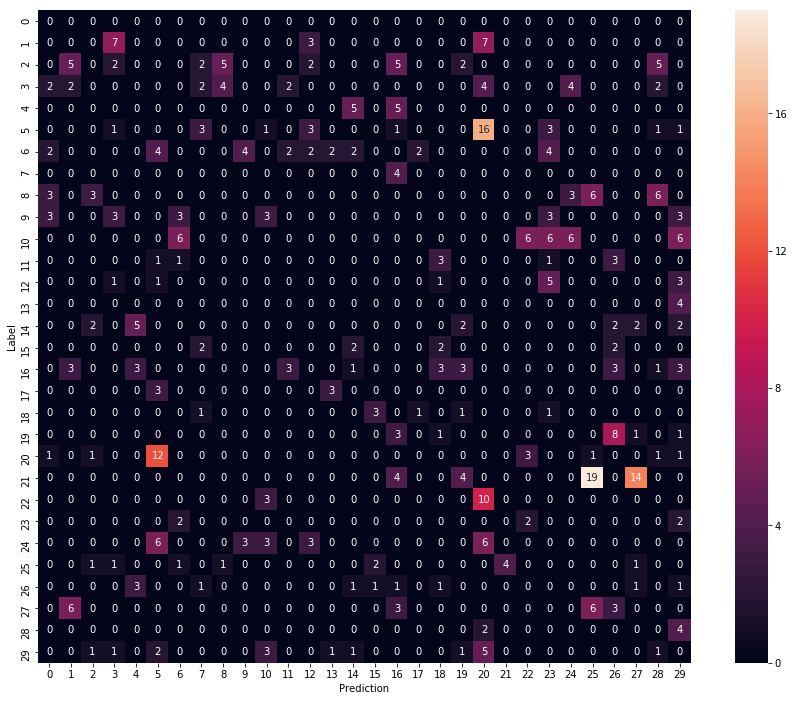

In [71]:
wrong_percentage = cm / row_sum.reshape((-1, 1))
np.fill_diagonal(wrong_percentage, 0)
plt.figure(figsize=(16, 12))
sns.heatmap((100 * wrong_percentage).astype(np.int32), annot=True, fmt="d", square=True)
plt.xlabel("Prediction")
plt.ylabel("Label")

In [239]:
id_to_class_name[24]

're_4_Wrapping_paper'

# Examples of wrong predictions

In [51]:
def wrong_predictions(predictions, labels, probs, filter_labels=None):
    idxs = np.argsort(probs)[::-1]
    for idx in idxs:
        if labels[idx] != predictions[idx] and \
            (filter_labels is None or labels[idx] == filter_labels):
            yield idx

In [240]:
wrong_idxs = list(wrong_predictions(predictions, labels, probs, filter_labels=24))

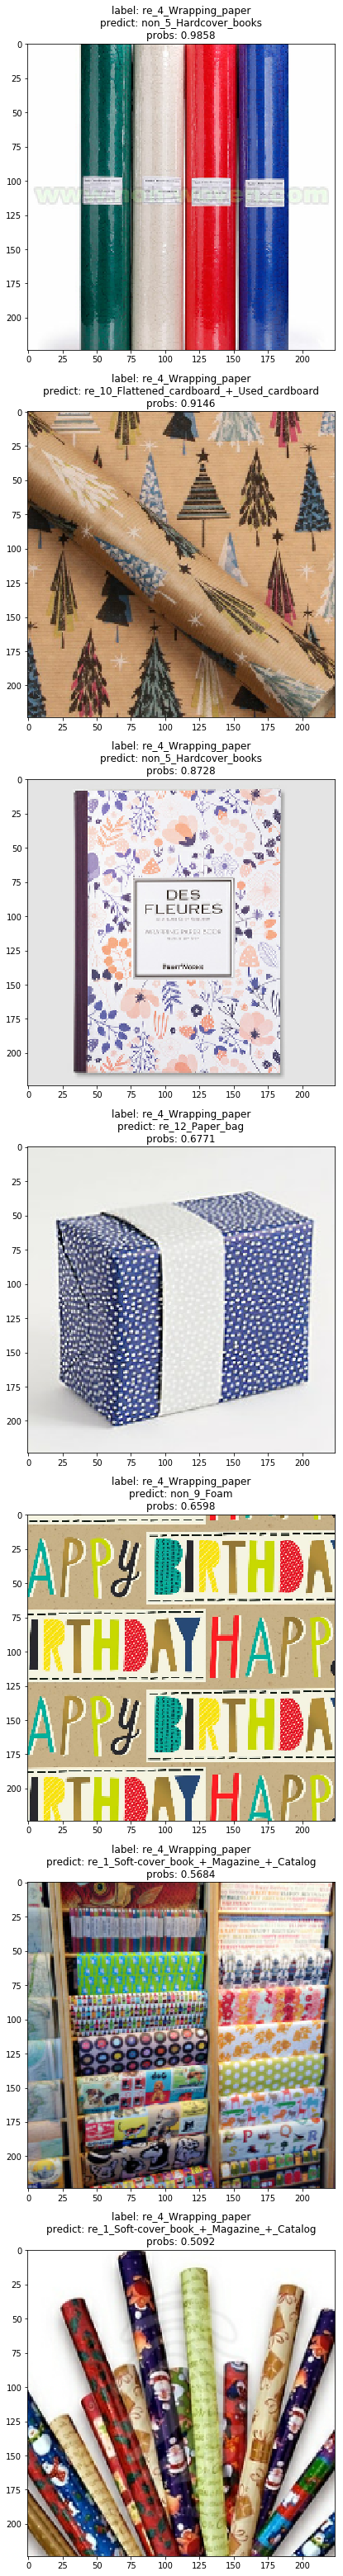

In [241]:
num_images = min(len(wrong_idxs), 20)
fig, axs = plt.subplots(num_images, figsize=(10, 8 * num_images))
for i, idx in enumerate(wrong_idxs[:num_images]):
    axs[i].imshow(images[idx])
    axs[i].set_title("label: {}\npredict: {}\nprobs: {:.4f}".format(
        id_to_class_name[labels[idx]], id_to_class_name[predictions[idx]], probs[idx]))

# ROC

In [217]:
binary_labels = labels > 9
binary_predictions = predictions > 9
conf = probs.copy()
conf[binary_predictions == 0] = 1 - conf[binary_predictions == 0]
idxs = np.argsort(conf)[::-1]

tp = 0
fp = 0
fn = np.sum(binary_labels == 1)
tn = np.sum(binary_labels == 0)
tpr, fpr, acc = [], [], []

for k, i in enumerate(idxs):
    if binary_labels[i]:
        tp += 1
        fn -= 1
    else:
        fp += 1
        tn -= 1
    tpr.append(tp / (tp + fn))
    fpr.append(fp / (fp + tn))
    acc.append((tp + tn) / (tp + tn + fp + fn))
    print(conf[i], tpr[-1], fpr[-1], acc[-1])
        

1.0 0.0010460251046 0.0 0.309971098266
1.0 0.00209205020921 0.0 0.310693641618
1.0 0.00313807531381 0.0 0.311416184971
1.0 0.00418410041841 0.0 0.312138728324
1.0 0.00523012552301 0.0 0.312861271676
1.0 0.00627615062762 0.0 0.313583815029
1.0 0.00732217573222 0.0 0.314306358382
1.0 0.00836820083682 0.0 0.315028901734
1.0 0.00941422594142 0.0 0.315751445087
1.0 0.010460251046 0.0 0.316473988439
1.0 0.0115062761506 0.0 0.317196531792
0.999999 0.0125523012552 0.0 0.317919075145
0.999999 0.0135983263598 0.0 0.318641618497
0.999999 0.0146443514644 0.0 0.31936416185
0.999999 0.015690376569 0.0 0.320086705202
0.999999 0.0167364016736 0.0 0.320809248555
0.999999 0.0177824267782 0.0 0.321531791908
0.999998 0.0188284518828 0.0 0.32225433526
0.999998 0.0198744769874 0.0 0.322976878613
0.999998 0.0209205020921 0.0 0.323699421965
0.999998 0.0219665271967 0.0 0.324421965318
0.999997 0.0230125523013 0.0 0.325144508671
0.999997 0.0240585774059 0.0 0.325867052023
0.999996 0.0251046025105 0.0 0.32658959

0.923664 0.713389121339 0.0280373831776 0.793352601156
0.922761 0.714435146444 0.0280373831776 0.794075144509
0.92233 0.715481171548 0.0280373831776 0.794797687861
0.91955 0.716527196653 0.0280373831776 0.795520231214
0.917461 0.717573221757 0.0280373831776 0.796242774566
0.916188 0.718619246862 0.0280373831776 0.796965317919
0.91521 0.719665271967 0.0280373831776 0.797687861272
0.914629 0.720711297071 0.0280373831776 0.798410404624
0.91353 0.721757322176 0.0280373831776 0.799132947977
0.912835 0.72280334728 0.0280373831776 0.799855491329
0.912244 0.72280334728 0.0303738317757 0.799132947977
0.911632 0.723849372385 0.0303738317757 0.799855491329
0.909226 0.72489539749 0.0303738317757 0.800578034682
0.908189 0.725941422594 0.0303738317757 0.801300578035
0.907508 0.726987447699 0.0303738317757 0.802023121387
0.907298 0.728033472803 0.0303738317757 0.80274566474
0.901958 0.729079497908 0.0303738317757 0.803468208092
0.899827 0.730125523013 0.0303738317757 0.804190751445
0.898441 0.7311715

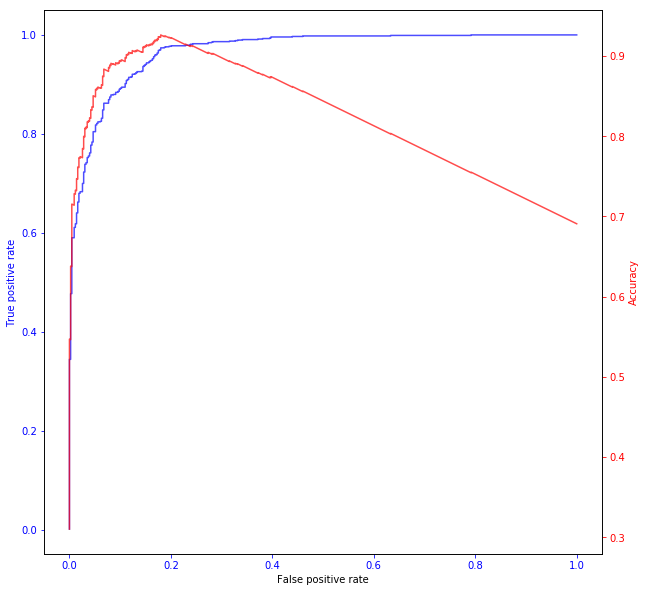

In [218]:
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.plot(fpr, tpr, 'b-', alpha=0.7)
ax1.set_xlabel("False positive rate")
ax1.set_ylabel("True positive rate", color='b')
ax1.tick_params(colors='b')

ax2 = ax1.twinx()
ax2.plot(fpr, acc, 'r-', alpha=0.7)
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params(colors='r')